In [1]:

%matplotlib inline
from itertools import chain, combinations
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
from abc import ABC
from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import nest_asyncio
nest_asyncio.apply()
from collections import defaultdict
from typing import Any

from sklearn import metrics
from matplotlib import pyplot as plt


/home/josh/workspace/bayesianquilts/env-3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_probability.python.bijectors as tfb

# pip install github:https://github.com/mederrata/bayesianquilts
from bayesianquilts.models.logistic_regression_reparam import LogisticRegression2
from bayesianquilts.metrics.classification import classification_metrics
from bayesianquilts.sampler import psis, nppsis

2025-05-29 19:14:23.482566: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 19:14:23.534510: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 19:14:23.586941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748546063.629250   59475 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748546063.641416   59475 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-29 19:14:23.742363: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:

X_ = pd.read_csv(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overianx.csv", header=None)
y_ = pd.read_table(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overiany.csv", header=None)


X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0).to_numpy()
y_ = y_.to_numpy()
N = X_scaled.shape[0]
d = X_scaled.shape[1]

print((N, d))

(54, 1536)


In [4]:
logistic_horseshoe_code = """
data {
  int <lower=0> N;                // number  of  observations
  int <lower=0> d;                // number  of  predictors
  array[N] int<lower=0,upper=1> y;      // outputs
  matrix[N,d] x;                  // inputs
  real <lower=0>  scale_icept;    // prior  std for  the  intercept
  real <lower=0>  scale_global;   // scale  for  the half -t prior  for  tau
  real <lower=1>  nu_global;      // degrees  of  freedom  for the half -t prior for tau
  real <lower=1> nu_local;        // degrees  of  freedom  for  the half -t priors for  lambdas
  real <lower=0>  slab_scale;     // slab  scale  for  the  regularized  horseshoe
  real <lower=0> slab_df;         // slab  degrees  of  freedom  for the  regularized horseshoe

  //int<lower=0> N_tilde;
  //matrix[N_tilde, d] x_tilde;
  //array[N_tilde] int<lower=0,upper=1> y_obs;
}
parameters {
  real  beta0;
  vector[d] z;
  real <lower=0> tau;             // global  shrinkage  parameter
  vector <lower =0>[d] lambda;    // local  shrinkage  parameter
  real <lower=0> caux;
}
transformed  parameters {
  vector <lower =0>[d] lambda_tilde;    // ’truncated ’ local  shrinkage  parameter
  real <lower=0> c;                     // slab  scale
  vector[d] beta;                       // regression  coefficients
  vector[N] f;                          // latent  function  values
  c = slab_scale * sqrt(caux);
  lambda_tilde = sqrt( c^2 * square(lambda) ./ (c^2 + tau^2* square(lambda )) );
  beta = z .*  lambda_tilde*tau;
  f = beta0 + x*beta;
}
model {
  z ~ normal(0.0, 1.0); // half -t priors  for  lambdas  and tau , and  inverse -gamma  for c^2
  lambda ~ student_t(nu_local , 0.0, 1.0);
  tau ~ student_t(nu_global , 0.0, scale_global);
  caux ~ inv_gamma (0.5* slab_df , 0.5* slab_df );
  beta0 ~ normal(0.0,  scale_icept );
  y ~ bernoulli_logit(f);
}
generated quantities {
  vector[N] log_lik;
  // vector[N_tilde] loo_log_lik;

  for (nn in 1:N)
    log_lik[nn] = bernoulli_logit_lpmf(y[nn] | x[nn] * beta + beta0);

  //for (nn in 1:N_tilde)
  //  loo_log_lik[nn] = bernoulli_logit_lpmf(y_obs[nn] | x_tilde[nn] * beta + beta0);
}
"""

with open("ovarian_model.stan", 'w') as f:
  f.writelines(logistic_horseshoe_code)


In [5]:
sm = CmdStanModel(stan_file="ovarian_model.stan")

19:14:26 - cmdstanpy - INFO - compiling stan file /home/josh/workspace/bayesianquilts/ovarian_model.stan to exe file /home/josh/workspace/bayesianquilts/ovarian_model
19:14:38 - cmdstanpy - INFO - compiled model executable: /home/josh/workspace/bayesianquilts/ovarian_model


In [6]:
guessnumrelevcov = N / 10  # 20.
slab_scale = 2.5
scale_icept = 5.0
nu_global = 1
nu_local = 1
slab_df = 1
scale_global = guessnumrelevcov / ((d - guessnumrelevcov) * np.sqrt(N))

control = {"adapt_delta": 0.9999, "max_treedepth": 15}

# shuffle

# shuffled_ndx = np.random.shuffle(np.arange(N))

ovarian_data = {
    "N": N,
    "d": d,
    "slab_df": slab_df,
    "slab_scale": slab_scale,
    "scale_icept": scale_icept,
    "nu_global": 1,
    "nu_local": 1,
    "scale_global": scale_global,
    "y": y_.astype(int)[:, 0].tolist(),
    "x": X_scaled.tolist(),
}

import json

with open("ovarian_data.json", "w") as f:
    json.dump(ovarian_data, f)

In [7]:
print(d)

1536


In [8]:
S = 1800
fit = sm.sample(
    data="ovarian_data.json",
    iter_warmup=15000,
    iter_sampling=S,
    thin=2,
    **control
)

19:14:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status









chain 1 |          | 00:10 Iteration:     1 / 16800 [  0%]  (Warmup)


chain 1 |▏         | 00:18 Iteration:   100 / 16800 [  0%]  (Warmup)



chain 1 |▏         | 00:25 Iteration:   200 / 16800 [  1%]  (Warmup)
chain 1 |▎         | 00:28 Iteration:   300 / 16800 [  1%]  (Warmup)
chain 1 |▎         | 00:32 Iteration:   400 / 16800 [  2%]  (Warmup)
chain 1 |▍         | 00:36 Iteration:   500 / 16800 [  2%]  (Warmup)


chain 1 |▌         | 00:45 Iteration:   700 / 16800 [  4%]  (Warmup)


chain 1 |▌         | 00:52 Iteration:   800 / 16800 [  4%]  (Warmup)


chain 1 |▋         | 00:57 Iteration:   900 / 16800 [  5%]  (Warmup)

chain 1 |▋         | 01:02 Iteration:  1000 / 16800 [  5%]  (Warmup)



chain 1 |▊         | 01:07 Iteration:  1100 / 16800 [  6%]  (Warmup)


chain 1 |▊         | 01:15 Iteration:  1200 / 16800 [  7%]  (Warmup)



chain 1 |▉         | 01:24 Iteration:  1300 / 16800 [  7%]  (Warmup)


chain 1 |▉         | 01:31 Iteration:  1400 / 16800 [  8%]  (Warmup)


chain


19:40:49 - cmdstanpy - INFO - CmdStan done processing.
19:40:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: ovarian_model_model_namespace::log_prob: lambda_tilde[1] is -nan, but must be greater than or equal to 0.000000 (in 'ovarian_model.stan', line 26, column 2 to column 36)
Exception: ovarian_model_model_namespace::log_prob: lambda_tilde[88] is -nan, but must be greater than or equal to 0.000000 (in 'ovarian_model.stan', line 26, column 2 to column 36)
Consider re-running with show_console=True if the above output is unclear!


19:40:50 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [9]:
print(fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
2 of 900 (0.22%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  lambda[1483], lambda_tilde[1483], beta[1483]
Such high values indicate incomplete mixing and biased estimation.
You should consider regularizating your model with additional prior information or a more effective parameterization.

Processing complete.



In [10]:
fit.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-2922.260000,0.978239,44.304800,44.181500,-2996.520000,-2921.520000,-2.851220e+03,2065.620,2749.520,0.999847
beta0,2.810850,0.045427,2.017190,1.651060,0.438770,2.365500,6.570020e+00,2005.380,2709.850,1.001490
z[1],0.067432,0.017617,0.979732,0.983477,-1.506760,0.057329,1.672430e+00,3100.900,2769.930,1.000000
z[2],-0.006524,0.017947,0.988911,0.998164,-1.611400,-0.011804,1.612180e+00,3047.570,2972.320,1.000740
z[3],0.028397,0.018188,0.997407,1.004310,-1.596190,0.016803,1.661510e+00,3014.350,2951.340,0.999827
...,...,...,...,...,...,...,...,...,...,...
log_lik[50],-0.007458,0.000942,0.053135,0.000059,-0.028137,-0.000039,-9.490830e-15,1278.080,2397.450,1.001720
log_lik[51],-0.008725,0.001184,0.061074,0.000025,-0.028524,-0.000017,-1.045980e-15,1119.620,1767.670,1.001430
log_lik[52],-0.021811,0.002057,0.106185,0.000076,-0.089963,-0.000051,-1.079040e-13,1596.060,2419.100,1.001360
log_lik[53],-0.526262,0.032973,0.821228,0.170342,-2.273800,-0.114894,-2.814320e-09,447.752,1926.750,1.001630


In [11]:
fit.stan_variable('beta0').shape

(3600,)

In [12]:
fit.stan_variable('beta').shape, X_scaled.shape

((3600, 1536), (54, 1536))

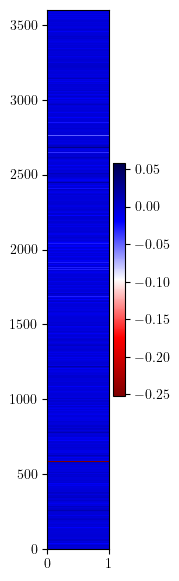

In [13]:
from matplotlib import pyplot as plt
beta = tf.reduce_mean(fit.stan_variable("beta"), axis=1, keepdims=True)
fig, ax = plt.subplots(1, 1, figsize=(1, 7))
im = ax.pcolormesh(beta, cmap='seismic_r')
plt.colorbar(im)

In [14]:
params = fit.stan_variables()
params.keys()
params['c'] = params['c'][:, tf.newaxis]
params['tau'] = params['tau'][:, tf.newaxis]
params['caux'] = params['caux'][:, tf.newaxis]
params['beta0'] = params['beta0'][:, tf.newaxis]


In [15]:
lr_model = LogisticRegression2(
    dim_regressors=d,
    slab_df=slab_df,
    slab_scale=slab_scale,
    scale_icept=scale_icept,
    nu_global=1,
    nu_local=1,
    scale_global=scale_global,
)

In [16]:
fit.stan_variable("beta").shape

(3600, 1536)

In [17]:
tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})
batch_size = N
def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

batch = next(iter(data_factory_factory()()))

0it [00:00, ?it/s]

1it [00:00,  1.87it/s]2025-05-29 19:41:29.550266: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
1it [00:00,  1.87it/s]


(0.0, 1.0)

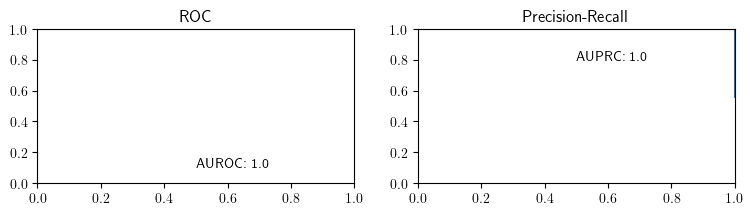

In [18]:
def prediction_fn(data):
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [19]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def adaptive_is_loo(
    self: LogisticRegression2,
    data: dict[str, tf.Tensor],
    params,
    hbar=1.0,
    variational=True,
) -> dict[str, Any]:
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma
    c = self.slab_scale * tf.math.sqrt(params["caux"])
    lambda_tilde = tf.math.sqrt(
        c**2
        * params["lambda"] ** 2
        / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
    )
    beta = params["z"] * lambda_tilde * params["tau"]
    intercept = params["beta0"]
    _X = tf.cast(data["X"], self.dtype)
    _y = tf.cast(data["y"], self.dtype)[:, 0]
    mu = beta[..., tf.newaxis, :] * _X
    mu = tf.reduce_sum(mu, -1) + params["beta0"]
    sigma = tf.math.sigmoid(mu)
    ell = _y * (sigma) + (1 - _y) * (1 - sigma)
    log_ell = tf.math.xlogy(_y, sigma) + tf.math.xlogy(1 - _y, 1 - sigma)
    log_ell_prime = _y * (1 - sigma) - (1 - _y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)
    _, khat0 = nppsis.psislw(-log_ell)

    """
    sigma.shape is samples x datapoints
    """

    ndx_to_transform = np.where(khat0 > 0.7)[0]
    ndx_to_leave = np.where((khat0 <= 0.7))[0]

    def IS(T, X, y):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)
        log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
        log_ell_doubleprime = -sigma * (1 - sigma)
        # compute # \nabla\log\pi(\btheta|\calD)
        if variational:
            # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
            grad_log_pi = tf.concat(
                [
                    -(
                        intercept
                        - self.surrogate_distribution.model["intercept__"].mean()
                    )
                    / self.surrogate_distribution.model["intercept__"].variance(),
                    -(beta - self.surrogate_distribution.model["beta__"].mean())
                    / self.surrogate_distribution.model["beta__"].variance(),
                ],
                axis=-1,
            )
            intercept_sd = (
                self.surrogate_distribution.model["intercept__"].variance() ** 0.5
            )
            beta_sd = self.surrogate_distribution.model["beta__"].variance() ** 0.5

            log_pi = self.surrogate_distribution.model["beta__"].log_prob(
                params["beta__"]
            ) + self.surrogate_distribution.model["intercept__"].log_prob(
                params["intercept__"]
            )
            log_pi -= tf.reduce_max(log_pi, axis=0)
            # log_pi.shape: [samples]
        else:
            """
            Recall Bayes rule:
            \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

            so
            \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

            """
            log_prior = self.prior_distribution.log_prob_parts(params)
            log_prior = log_prior["z"] + log_prior["beta0"]

            log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]

            # pi \propto
            grad_log_pi = tf.concat(
                [
                    tf.reduce_sum(
                        log_ell_prime[..., tf.newaxis], axis=1, keepdims=True
                    ),
                    tf.reduce_sum(
                        log_ell_prime[..., tf.newaxis] * X, axis=1, keepdims=True
                    ),
                ],
                axis=-1,
            )

            grad_log_prior = -0.5 * tf.concat(
                [(params["beta0"] / self.scale_icept) ** 2, (params["z"]) ** 2],
                axis=-1,
            )
            grad_log_pi += grad_log_prior[:, tf.newaxis, :]

            intercept_sd = tf.math.reduce_std(intercept, 0, keepdims=True)
            beta_sd = tf.math.reduce_std(beta, 0, keepdims=True)

        beta_new, intercept_new, logJ = T(
            X,
            y,
            log_pi=log_pi,
            grad_log_pi=grad_log_pi,
            beta_sd=beta_sd,
            intercept_sd=intercept_sd,
        )
        mu_new = tf.reduce_sum(beta_new * X, axis=-1) + intercept_new[..., 0]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.sqrt(
            c**2
            * params["lambda"] ** 2
            / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
        )
        transformed = params.copy()
        transformed["z"] = beta_new / (
            lambda_tilde[:, tf.newaxis, :] * params["tau"][..., tf.newaxis]
        )
        transformed["beta0"] = intercept_new

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )
            pass
        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = tf.math.sigmoid(
                tf.reduce_sum(beta_new[..., tf.newaxis, :] * X, -1) + intercept_new
            )
            ell_cross = tf.math.xlogy(y, ell_cross) + tf.math.xlogy(
                1 - y, 1 - ell_cross
            )
            ell_cross = tf.math.reduce_sum(ell_cross, axis=-1)

            log_prior_new = self.prior_distribution.log_prob_parts(transformed)
            log_prior_new = log_prior_new["z"] + log_prior_new["beta0"]
            log_pi_new = ell_cross
            delta_log_prior = log_prior_new - log_prior[:, tf.newaxis]
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi[:, tf.newaxis] + delta_log_prior

        # regularize delta_log_pi

        def regularize(tensor):
            min_finite = tf.reduce_min(
                tf.where(
                    tf.math.is_finite(tensor),
                    tensor,
                    tf.zeros_like(tensor),
                )
            )
            return tf.where(
                tf.math.is_finite(tensor),
                tensor,
                min_finite * tf.ones_like(tensor),
            )

        delta_log_pi = regularize(delta_log_pi)
        delta_log_pi -= tf.reduce_max(delta_log_pi, axis=0)
        log_eta_weights = delta_log_pi - regularize(log_ell_new) + logJ
        log_eta_weights = log_eta_weights - tf.reduce_max(log_eta_weights, axis=0)
        psis_weights, khat = nppsis.psislw(log_eta_weights)

        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = self.entropy(eta_weights)
        psis_entropy = self.entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        return (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )

    # log-likelihood descent

    def T_ll(X, y, log_pi, beta_sd, intercept_sd, **kwargs):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)

        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma

        Q_beta = -log_ell_prime[..., tf.newaxis] * X
        Q_intercept = -log_ell_prime[..., tf.newaxis]

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized
        logJ = tf.math.log1p(
            tf.math.abs(
                h
                * (1 + tf.math.reduce_sum(X**2, -1, keepdims=True))[tf.newaxis, :, :]
                * (sigma * (1 - sigma))[..., tf.newaxis]
            )[..., 0]
        )
        beta_ll = beta[..., tf.newaxis, :] + h * Q_beta
        intercept_ll = intercept[..., tf.newaxis, :] + h * Q_intercept
        return beta_ll, intercept_ll, logJ

    def T_kl(X, y, log_pi, grad_log_pi, beta_sd, intercept_sd):
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        Q_beta = ((-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ] * X
        Q_intercept = (
            ((-1) ** y) * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (-1) ** y[tf.newaxis, :] * tf.math.exp(
            log_pi_[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :])
        )
        dQ *= (
            grad_log_pi[..., 0]
            + (1 - 2 * y)[tf.newaxis, :]
            + tf.reduce_sum(
                X
                * (
                    grad_log_pi[..., 1:]
                    + (1 - 2 * y)[:, tf.newaxis] * X[tf.newaxis, ...]
                ),
                axis=-1,
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept[..., tf.newaxis] + h * Q_intercept
        beta_kl = beta[..., tf.newaxis, :] + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def T_I(X, y, **kwargs):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)

        log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
        Q = tf.zeros_like(log_ell)
        return (
            beta[:, tf.newaxis, :] + Q[..., tf.newaxis],
            intercept[..., tf.newaxis] + Q[..., tf.newaxis],
            tf.zeros_like(Q),
        )

    def T_var(X, y, log_pi, grad_log_pi, beta_sd, intercept_sd, **kwargs):
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        Q_beta = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis] * X
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(
                log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y[tf.newaxis, :])
            )
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + 2 * (1 - 2 * y)[:, tf.newaxis] * X),
                    axis=-1,
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept[..., tf.newaxis, :] + h * Q_intercept
        beta_kl = beta[..., tf.newaxis, :] + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def T_PMM1(X, y, **kwargs):
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.abs(c) / tf.math.sqrt(
            (c / params["lambda"]) ** 2 + params["tau"] ** 2
        )
        beta = params["z"] * lambda_tilde * params["tau"]
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_hat(param):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat) ** 2)
            v_w = tf.reduce_sum(
                weights * (param[:, tf.newaxis, ...] - hat) ** 2, axis=0, keepdims=True
            )
            return hat, hat_w, v, v_w

        beta_hat, beta_hat_w, beta_v, beta_v_w = theta_hat(beta)
        beta0_hat, beta0_hat_w, beta0_v, beta0_v_w = theta_hat(params["beta0"])

        # tf.math.exp(0.5*(tf.math.log(beta_v_w) - tf.math.log(beta_v)))-tf.math.sqrt(beta_v_w / beta_v)

        beta_adj = beta[:, tf.newaxis, ...] + hbar * (-beta_hat + beta_hat_w)
        beta0_adj = params["beta0"][:, tf.newaxis, ...] + hbar * (
            -beta0_hat + beta0_hat_w
        )

        # shift by mean
        return beta_adj, beta0_adj, tf.zeros_like(ell)

    def T_PMM2(X, y, **kwargs):
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.abs(c) / tf.math.sqrt(
            (c / params["lambda"]) ** 2 + params["tau"] ** 2
        )
        beta = params["z"] * lambda_tilde * params["tau"]
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_hat(param):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat) ** 2)
            v_w = tf.reduce_sum(
                weights * (param[:, tf.newaxis, ...] - hat) ** 2, axis=0, keepdims=True
            )
            return hat, hat_w, v, v_w

        beta_hat, beta_hat_w, beta_v, beta_v_w = theta_hat(beta)
        beta0_hat, beta0_hat_w, beta0_v, beta0_v_w = theta_hat(params["beta0"])

        # tf.math.exp(0.5*(tf.math.log(beta_v_w) - tf.math.log(beta_v)))-tf.math.sqrt(beta_v_w / beta_v)

        beta_adj = beta[:, tf.newaxis, ...] + hbar * (
            (tf.math.sqrt(beta_v_w / beta_v) - 1) * beta[:, tf.newaxis, ...]
            - tf.math.sqrt(beta_v_w / beta_v) * beta_hat
            + beta_hat_w
        )
        beta0_adj = params["beta0"][:, tf.newaxis, ...] + hbar * (
            (tf.math.sqrt(beta0_v_w / beta0_v) - 1)
            * params["beta0"][:, tf.newaxis, ...]
            - tf.math.sqrt(beta0_v_w / beta0_v) * beta0_hat
            + beta0_hat_w
        )

        lJ = tf.math.log(
            1
            + hbar
            * (
                beta.shape[-1]
                * tf.ones_like(ell)
                * (tf.math.sqrt(beta0_v_w / beta0_v) - 1)[..., 0]
            )
        )
        lJ += tf.math.log(1 + hbar * (tf.math.sqrt(beta0_v_w / beta0_v) - 1)[..., 0])

        # shift by mean
        return beta_adj, beta0_adj, lJ
    
    def T_MM1(X, y, **kwargs):
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.abs(c) / tf.math.sqrt(
            (c / params["lambda"]) ** 2 + params["tau"] ** 2
        )
        beta = params["z"] * lambda_tilde * params["tau"]
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_hat(param):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat) ** 2)
            v_w = tf.reduce_sum(
                weights * (param[:, tf.newaxis, ...] - hat) ** 2, axis=0, keepdims=True
            )
            return hat, hat_w, v, v_w

        beta_hat, beta_hat_w, beta_v, beta_v_w = theta_hat(beta)
        beta0_hat, beta0_hat_w, beta0_v, beta0_v_w = theta_hat(params["beta0"])

        # tf.math.exp(0.5*(tf.math.log(beta_v_w) - tf.math.log(beta_v)))-tf.math.sqrt(beta_v_w / beta_v)

        beta_adj = beta[:, tf.newaxis, ...] + 1 * (-beta_hat + beta_hat_w)
        beta0_adj = params["beta0"][:, tf.newaxis, ...] + 1 * (
            -beta0_hat + beta0_hat_w
        )

        # shift by mean
        return beta_adj, beta0_adj, tf.zeros_like(ell)

    def T_MM2(X, y, **kwargs):
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.abs(c) / tf.math.sqrt(
            (c / params["lambda"]) ** 2 + params["tau"] ** 2
        )
        beta = params["z"] * lambda_tilde * params["tau"]
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_hat(param):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat) ** 2)
            v_w = tf.reduce_sum(
                weights * (param[:, tf.newaxis, ...] - hat) ** 2, axis=0, keepdims=True
            )
            return hat, hat_w, v, v_w

        beta_hat, beta_hat_w, beta_v, beta_v_w = theta_hat(beta)
        beta0_hat, beta0_hat_w, beta0_v, beta0_v_w = theta_hat(params["beta0"])

        # tf.math.exp(0.5*(tf.math.log(beta_v_w) - tf.math.log(beta_v)))-tf.math.sqrt(beta_v_w / beta_v)

        beta_adj = beta[:, tf.newaxis, ...] + 1 * (
            (tf.math.sqrt(beta_v_w / beta_v) - 1) * beta[:, tf.newaxis, ...]
            - tf.math.sqrt(beta_v_w / beta_v) * beta_hat
            + beta_hat_w
        )
        beta0_adj = params["beta0"][:, tf.newaxis, ...] + 1 * (
            (tf.math.sqrt(beta0_v_w / beta0_v) - 1)
            * params["beta0"][:, tf.newaxis, ...]
            - tf.math.sqrt(beta0_v_w / beta0_v) * beta0_hat
            + beta0_hat_w
        )

        lJ = tf.math.log(
            1
            + 1
            * (
                beta.shape[-1]
                * tf.ones_like(ell)
                * (tf.math.sqrt(beta0_v_w / beta0_v) - 1)[..., 0]
            )
        )
        lJ += tf.math.log(1 + 1 * (tf.math.sqrt(beta0_v_w / beta0_v) - 1)[..., 0])

        # shift by mean
        return beta_adj, beta0_adj, lJ

    X_ = tf.gather(_X, ndx_to_leave)
    y_ = tf.gather(_y, ndx_to_leave)
    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I, X_, y_)

    out = {
        "I0": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I,
            "ndx": ndx_to_leave,
        }
    }

    transforms = {
        "PMM1": T_PMM1,
        "PMM2": T_PMM2,
        "MM1": T_MM1,
        "MM2": T_MM2,
        "I": T_I,
        "KL": T_kl,
        "Var": T_var,
        "LL": T_ll,
    }

    X_ = tf.gather(_X, ndx_to_transform)
    y_ = tf.gather(_y, ndx_to_transform)
    for lab, fun in transforms.items():
        (
            eta_,
            eta_psis_,
            p_loo_,
            p_loo_sd_,
            ll_loo_,
            ll_loo_s_d,
            S_,
            k_,
            p_psis_,
            ll_psis_,
        ) = IS(fun, X_, y_)

        out = {
            **out,
            lab: {
                "p_loo": p_loo_,
                "p_loo_sd": p_loo_sd_,
                "ll_loo": ll_loo_,
                "ll_loo_sd": ll_loo_s_d,
                "S": S_,
                "khat": k_,
                "p_psis": p_psis_,
                "ll_psis": ll_psis_,
                "ndx": ndx_to_transform,
            },
        }

    return {**out, "ndx_transformed": ndx_to_transform}


nparams = 64
loo = adaptive_is_loo(
    lr_model,
    batch,
    {k: v[:nparams, ...] for k, v in params.items()},
    1e-5,
    variational=False,
)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "LL", "KL", "Var", "PMM1", "PMM2", "MM1", "MM2"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
    )

<>:90: SyntaxWarning: invalid escape sequence '\l'
<>:90: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_59475/3009492544.py:90: SyntaxWarning: invalid escape sequence '\l'
  """


I: 0.09345044945409092 entropy: 10.096039159438442 khat>0.7: 26
LL: 0.09191923989141527 entropy: 10.107670946830723 khat>0.7: 24
KL: 0.09302074562159754 entropy: 10.098681830728093 khat>0.7: 26
Var: 0.09181812413387865 entropy: 10.103204006532723 khat>0.7: 25
PMM1: 0.09210488172813742 entropy: 10.077550222358715 khat>0.7: 17
PMM2: 0.10858664527209086 entropy: 9.75136743854174 khat>0.7: 13
MM1: 0.5105984194770584 entropy: 1.3888891087195496 khat>0.7: 26
MM2: nan entropy: nan khat>0.7: 26


In [41]:
base = 4
h_vals = [base**-r for r in range(11)]
loo_output = []
n_sample = [1000]
success = []
transforms = ["KL", "Var", "PMM1", "PMM2", "MM1", "MM2", "LL"]

for _ in tqdm(range(10)):
    loo_khat = {}
    reduced_ndx = {}
    high_khat_ndx = {}
    records = []
    for n_samples in n_sample:
        sample_ndx = np.random.choice(
            range(fit.stan_variables()["beta0"].shape[0]), size=n_samples, replace=False
        )
        reduced_ndx[n_samples] = {}
        high_khat_ndx[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat[n_samples] = {}
        params_ = fit.stan_variables()
        params_ = {k: v[sample_ndx] for k, v in params_.items()}
        params_["c"] = params_["c"][:, tf.newaxis]
        params_["tau"] = params_["tau"][:, tf.newaxis]
        params_["caux"] = params_["caux"][:, tf.newaxis]
        params_["beta0"] = params_["beta0"][:, tf.newaxis]
        for h in h_vals:
            loo_khat[n_samples][h] = {}
            loo = adaptive_is_loo(lr_model, batch, params_, h, variational=False)
            reduced_ndx[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I0", "I", "LL", "KL", "Var", "PMM1", "PMM2", "MM1", "MM2"]:
                loo_khat[n_samples][h][T] = np.array(loo[T]["khat"])
                records += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"],
                    }
                ]
                reduced_ndx[n_samples][h][T] = [
                    loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]
                ]
    df = pd.DataFrame(records)
    df["rho_rank"] = np.emath.logn(base, df["h"])
    __df__ = df.explode(["khat", "ndx"])[["ndx", "khat", "T"]]

    counts = {}
    counts["n"] = len(__df__[__df__["T"] != "I0"].ndx.unique())
    for T in transforms:
        ___df__ = __df__.loc[(__df__["T"] == T) & (__df__["khat"] < 0.7)]
        counts[T] = ___df__.groupby("ndx").min().shape[0]

    ___df__ = __df__.loc[
        (
            (__df__["T"] == "KL")
            | (__df__["T"] == "Var")
            | (__df__["T"] == "PMM1")
            | (__df__["T"] == "PMM2")
        )
        & (__df__["khat"] < 0.7)
    ]
    counts[("KL", "Var", "PMM1", "PMM2")] = ___df__.groupby("ndx").min().shape[0]

    ___df__ = __df__.loc[
        ((__df__["T"] == "MM1") | (__df__["T"] == "MM2") | (__df__["T"] == "LL"))
        & (__df__["khat"] < 0.7)
    ]
    counts[("MM1", "MM2", "LL")] = ___df__.groupby("ndx").min().shape[0]
    ___df__ = __df__.loc[
        (
            (__df__["T"] == "MM1")
            | (__df__["T"] == "MM2")
            | (__df__["T"] == "PMM1")
            | (__df__["T"] == "PMM2")
            | (__df__["T"] == "KL")
            | (__df__["T"] == "LL")
            | (__df__["T"] == "Var")

        )
        & (__df__["khat"] < 0.7)
    ]
    counts[("KL", "Var", "MM1", "MM2", "LL", "PMM1", "PMM2")] = ___df__.groupby("ndx").min().shape[0]
    success += [counts]
print(reduced_ndx)

100%|██████████| 10/10 [38:58<00:00, 233.85s/it]

{1000: {1: {'I0': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 18, 19, 20, 27, 31, 32, 34, 38, 39, 40, 44, 46, 47, 49, 52], 'I': [], 'LL': [51], 'KL': [], 'Var': [42], 'PMM1': [], 'PMM2': [], 'MM1': [], 'MM2': []}, 0.25: {'I0': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 18, 19, 20, 27, 31, 32, 34, 38, 39, 40, 44, 46, 47, 49, 52], 'I': [], 'LL': [], 'KL': [], 'Var': [1, 23, 24], 'PMM1': [36], 'PMM2': [], 'MM1': [], 'MM2': []}, 0.0625: {'I0': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 18, 19, 20, 27, 31, 32, 34, 38, 39, 40, 44, 46, 47, 49, 52], 'I': [], 'LL': [], 'KL': [15, 26, 29, 42], 'Var': [1, 12, 23, 24, 29, 30, 35, 42], 'PMM1': [17, 21, 25, 26, 28, 33, 36, 41, 45, 50], 'PMM2': [], 'MM1': [], 'MM2': []}, 0.015625: {'I0': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 18, 19, 20, 27, 31, 32, 34, 38, 39, 40, 44, 46, 47, 49, 52], 'I': [], 'LL': [], 'KL': [12], 'Var': [1, 12, 22, 23, 24, 30, 35, 42], 'PMM1': [17, 21, 22, 25, 26, 28, 43, 45, 48], 'PMM2': [], 'MM1': [], 'MM2

In [42]:
success = pd.DataFrame(success)
success_ = success.copy()
success_.iloc[:, 1:] = -success_.iloc[:, 1:].sub(success_.iloc[:, 0], axis=1)

/tmp/ipykernel_59475/438181115.py:3: RuntimeWarning: '<' not supported between instances of 'int' and 'tuple', sort order is undefined for incomparable objects.
  success_.iloc[:, 1:] = -success_.iloc[:, 1:].sub(success_.iloc[:, 0], axis=1)
/tmp/ipykernel_59475/438181115.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: KL, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  success_.iloc[:, 1:] = -success_.iloc[:, 1:].sub(success_.iloc[:, 0], axis=1)
/tmp/ipykernel_59475/438181115.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: Var, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compat

In [43]:
success.agg(['mean','std'])


,n,KL,Var,PMM1,PMM2,MM1,MM2,LL,"(KL, Var, PMM1, PMM2)","(MM1, MM2, LL)","(KL, Var, MM1, MM2, LL, PMM1, PMM2)"
mean,30.800000,14.100000,15.300000,26.500000,24.700000,0.0,0.0,11.900000,30.50000,11.900000,30.700000
std,3.994441,3.446415,3.164034,2.592725,3.772709,0.0,0.0,3.541814,3.95109,3.541814,4.110961


In [44]:
(-success.iloc[:, 1:].sub(success.iloc[:, 0], axis=0)).agg(['mean','std'])


,KL,Var,PMM1,PMM2,MM1,MM2,LL,"(KL, Var, PMM1, PMM2)","(MM1, MM2, LL)","(KL, Var, MM1, MM2, LL, PMM1, PMM2)"
mean,16.700000,15.500000,4.300000,6.10000,30.800000,30.800000,18.900000,0.300000,18.900000,0.100000
std,1.946507,2.505549,2.057507,2.13177,3.994441,3.994441,2.514403,0.483046,2.514403,0.316228


In [24]:
df = pd.DataFrame(records)
df["rho_rank"] = np.emath.logn(base, df["h"])
df.head()

df_exploded = {}

for T in ["I0", "I", "LL", "KL", "Var", "PMM1", "PMM2", "MM1", "MM2"]:
    df_exploded[T] = df.loc[(df["S"] == n_sample[-1]) & (df["T"] == T)]
    df_exploded[T] = df_exploded[T].explode(["khat", "ndx"])

original = df_exploded["I"][["khat", "ndx"]].drop_duplicates()

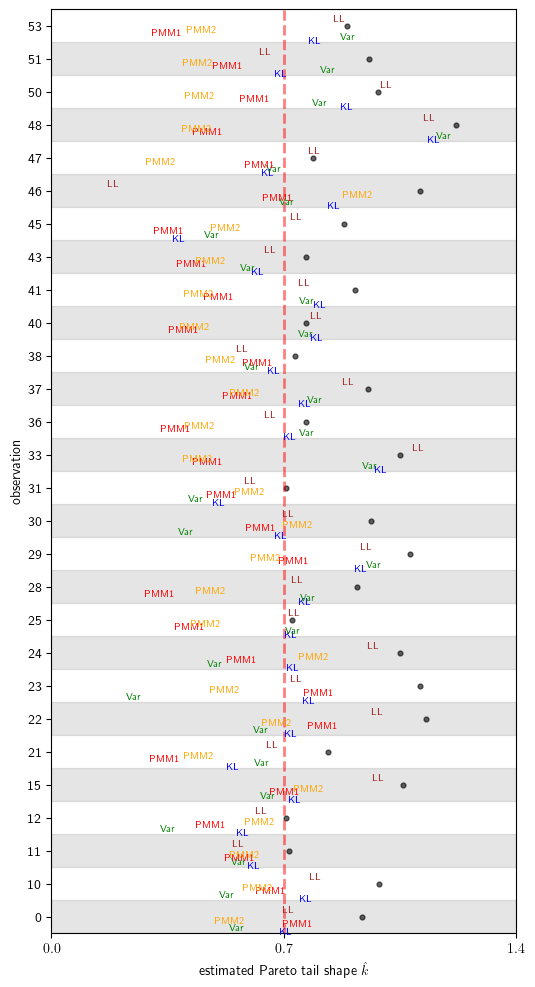

In [25]:
fig = plt.figure(figsize=(6, 12))
ndx_high_khat = loo["KL"]["ndx"].tolist()
ymax = len(ndx_high_khat)

_ = plt.scatter(
    original.khat,
    np.array([ndx_high_khat.index(i) for i in original["ndx"]]),
    color="black",
    s=12,
    alpha=0.6,
)
_ = plt.xlim((-0.5, 2))

T_colors = ["blue", "green", "red", "orange", "purple", "tan", "brown"]

for j, T in enumerate(["KL", "Var", "PMM1", "PMM2", "MM1", "MM2", "LL"]):
    df_exploded[T] = df_exploded[T][df_exploded[T].khat < 3]
    _ = plt.scatter(
        df_exploded[T].khat,
        np.array([ndx_high_khat.index(i) for i in df_exploded[T]["ndx"]]) + (j - 4) / 8,
        s=1,
        alpha=0,
    )

# kl_ = kl_[kl_.khat<3]

_ = plt.axvline(x=0.7, linestyle="dashed", linewidth=2, color="red", alpha=0.5)

T_vals = defaultdict(lambda: defaultdict(list))

for j, T in enumerate(["KL", "Var", "PMM1", "PMM2", "MM1", "MM2", "LL"]):
    for x, y, s in zip(
        df_exploded[T].khat,
        df_exploded[T]["ndx"],
        df_exploded[T]["rho_rank"].values.astype("int"),
    ):
        T_vals[T][y] += [x]

    for x, v in T_vals[T].items():
        plt.plot(
            min(v), ndx_high_khat.index(x) + (j - 4) / 9, color=T_colors[j], alpha=0.3
        )
        plt.text(
            min(v),
            ndx_high_khat.index(x) + (j - 4) / 9,
            T,
            ha="center",
            va="center",
            color=T_colors[j],
            fontsize=7,
            fontweight='bold'
        )


_ = plt.ylabel("observation")
_ = plt.ylim(-0.5, ymax - 0.5)
_ = plt.xlabel(r"estimated Pareto tail shape $\hat{k}$")
_ = plt.yticks(ticks=np.arange(ymax), labels=loo["KL"]["ndx"])
_ = plt.xticks([0, 0.7, 1.4])
_ = plt.xlim((0, 1.4))

for y0, y1 in zip(np.arange(ymax + 1)[::2] - 0.5, np.arange(ymax + 1)[::2] + 0.5):
    plt.axhspan(y0, y1, color="black", alpha=0.1, zorder=0)
# _ = plt.xlim((-0.1, 2))
_ = plt.savefig("khat_lr.pdf", bbox_inches='tight')

# Cross-tabulations

# Compare with variational model

In [ ]:
_df = df.explode(['khat','ndx'])[['rho_rank', 'T', 'ndx', 'khat']]
_df['rho_rank'] *= -1

In [ ]:
base_khat = _df[_df['T']=="I"][['ndx', 'khat']].drop_duplicates().to_dict(orient='records')
base_khat = {r['ndx']: r['khat'] for r in base_khat}


In [ ]:
_df = _df[(_df["T"]!="I") & (_df["T"]!="I0")]
_df[r'$\log(\hat{k}/\hat{k}_0)$'] = _df.apply(lambda x: x.khat/base_khat[x.ndx], axis=1)
_df[r'$-log_4(\rho)$'] = _df['rho_rank']

/tmp/ipykernel_3246782/2716067429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[r'$\log(\hat{k}/\hat{k}_0)$'] = _df.apply(lambda x: x.khat/base_khat[x.ndx], axis=1)
/tmp/ipykernel_3246782/2716067429.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[r'$-log_4(\rho)$'] = _df['rho_rank']


In [ ]:
_df = _df[_df[r'$\log(\hat{k}/\hat{k}_0)$']<4]

/home/josh/workspace/readmission/env/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


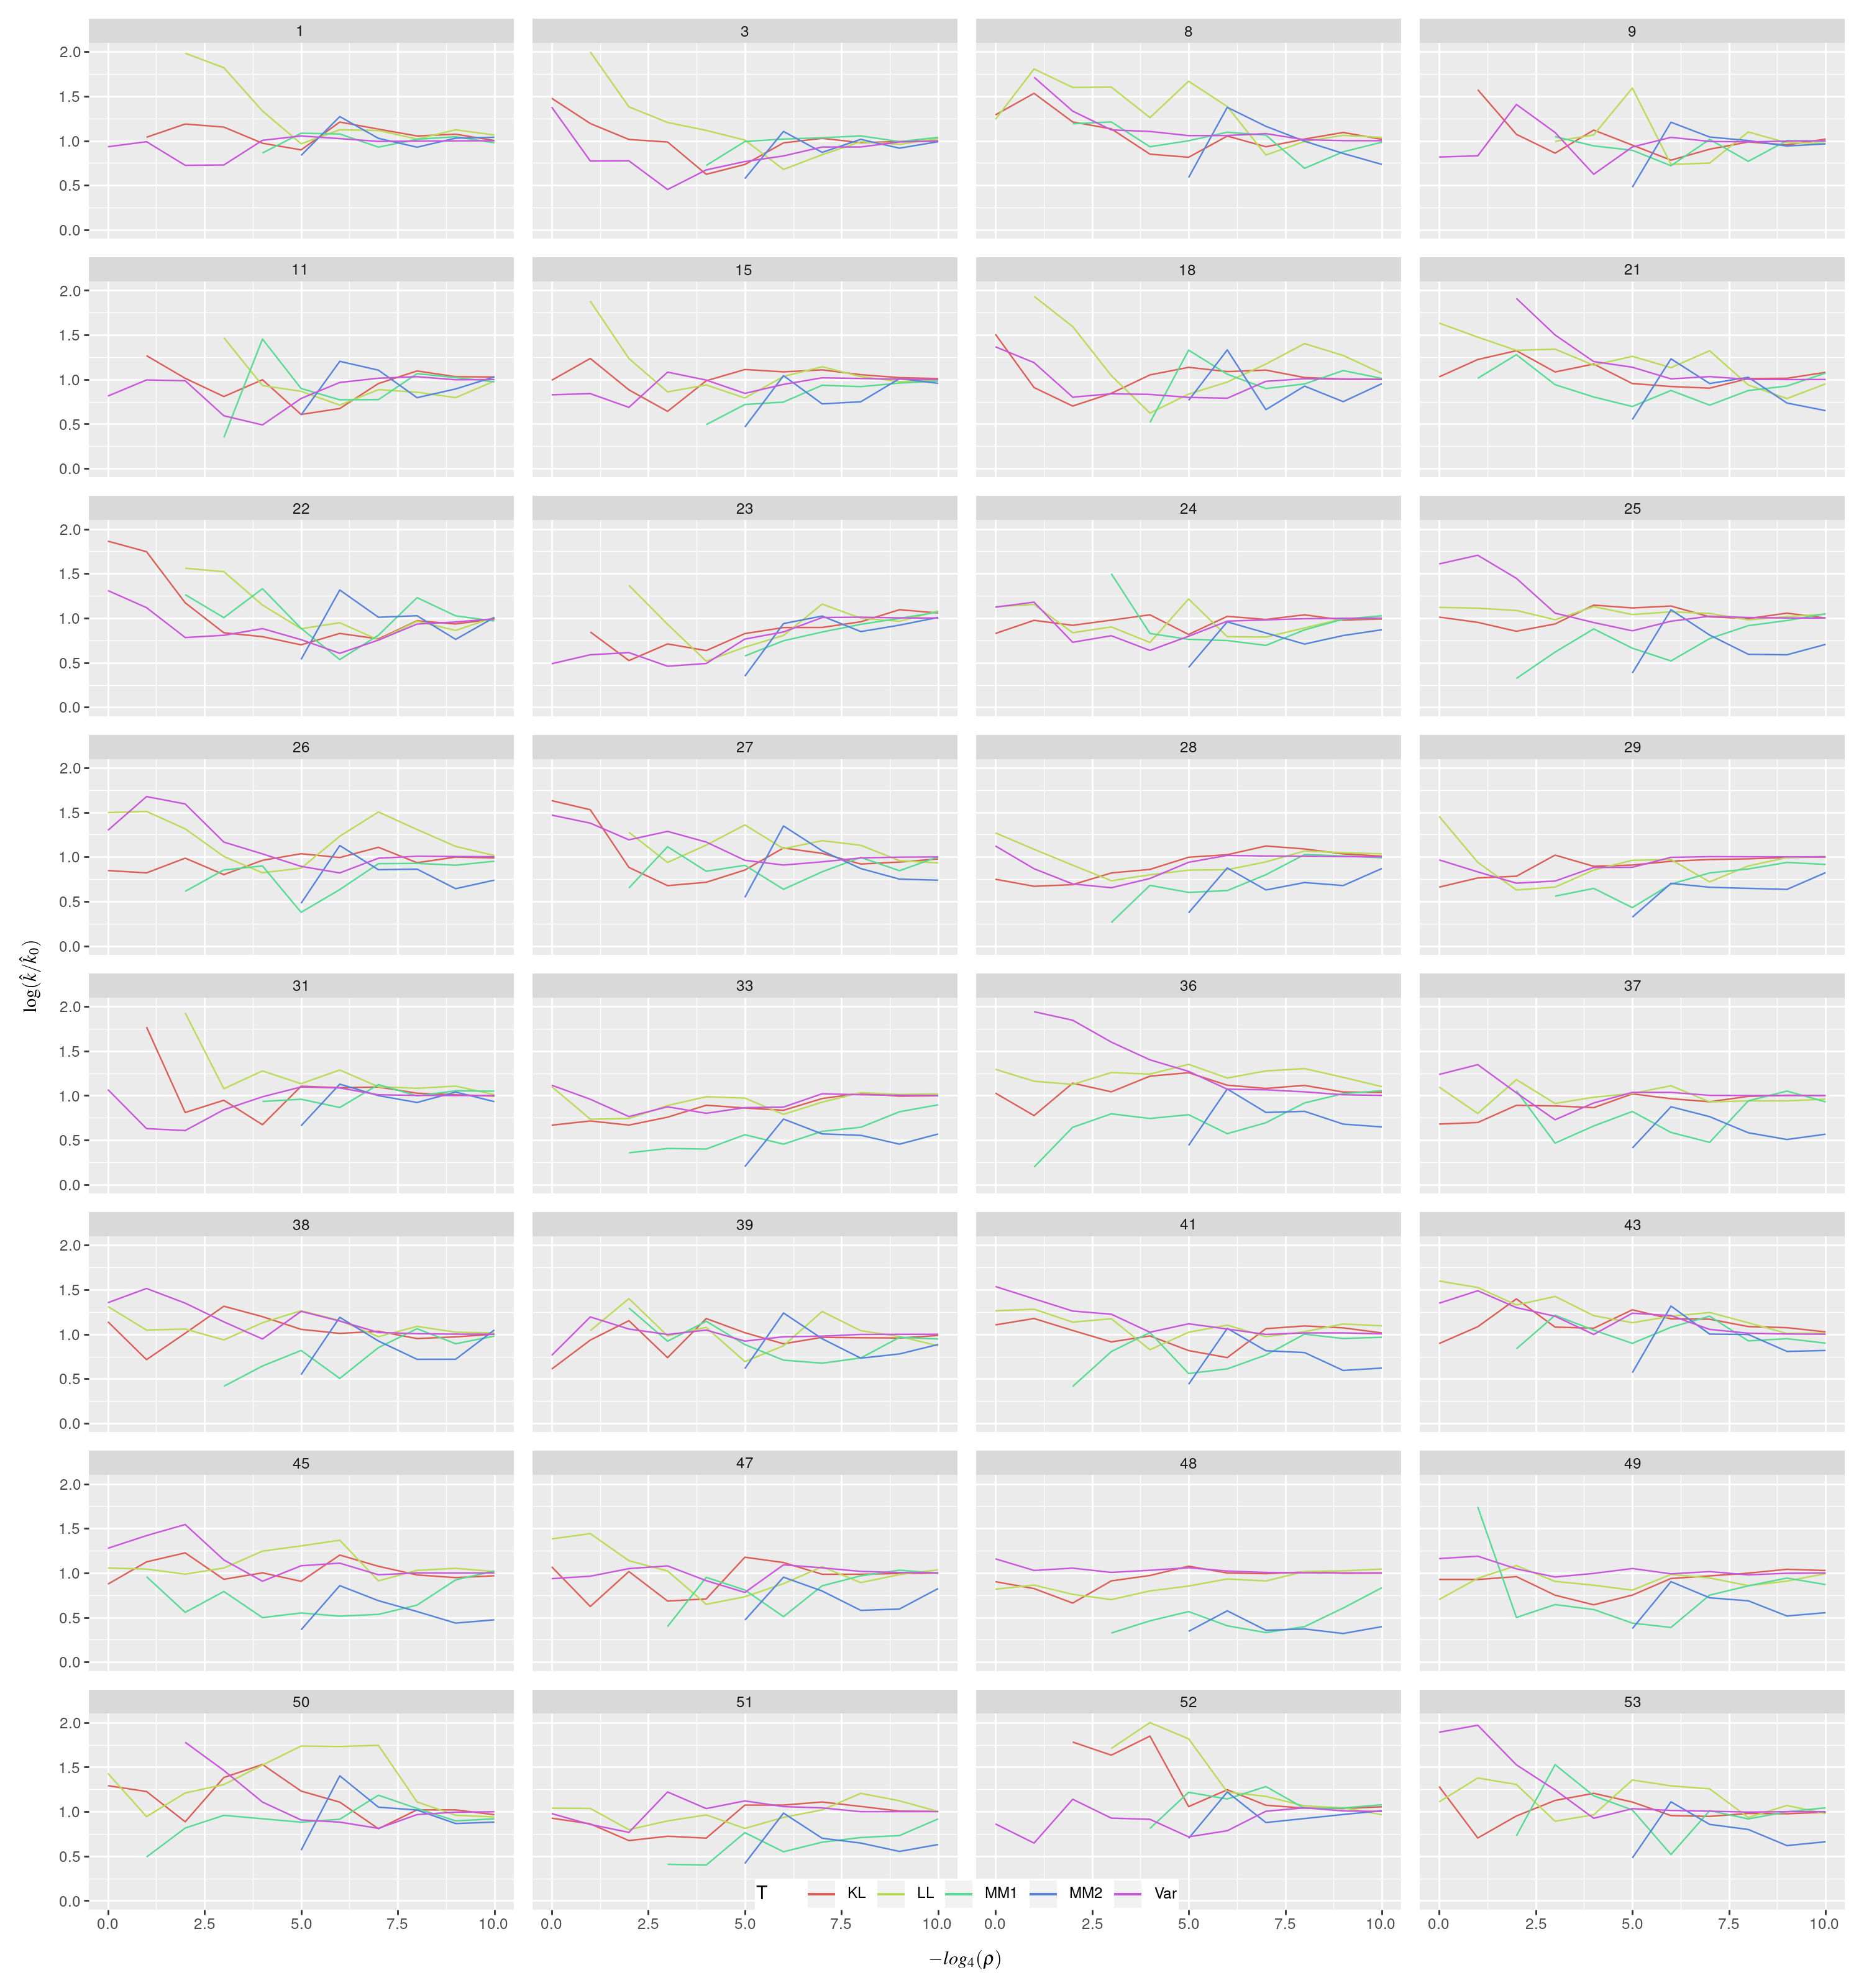

/home/josh/workspace/readmission/env/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 15 x 16 in image.
/home/josh/workspace/readmission/env/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: rho_rank.pdf
/home/josh/workspace/readmission/env/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


In [ ]:
from plotnine import ggplot, geom_line, geom_point, aes, stat_smooth, facet_wrap, theme, ylim
from plotnine.data import mtcars


plot = (
    ggplot(_df, aes(r'$-log_4(\rho)$', r'$\log(\hat{k}/\hat{k}_0)$', color="T"))
    + geom_line()
    + facet_wrap("ndx", ncol=4)
    + theme(figure_size=(15, 16), legend_position=(.5, .0), legend_direction='horizontal') + ylim((0, 2))
    
)
plot.show()
plot.save("rho_rank.pdf")